parsing log, completed traces ::   0%|          | 0/5000 [00:00<?, ?it/s]

The process discovered from the log consists of 7 activities, 3 resources, 33910 events related to 5000 cases, and 67 different execution paths (process variants).


exporting log, completed traces ::   0%|          | 0/5000 [00:00<?, ?it/s]

Basic Statistics
        case:concept:name                        concept:name  \
count        34003.000000                               34003   
unique                NaN                                   7   
top                   NaN  Move the container to Storage Area   
freq                  NaN                                9508   
mean          2501.042173                                 NaN   
min              1.000000                                 NaN   
25%           1250.000000                                 NaN   
50%           2500.000000                                 NaN   
75%           3753.000000                                 NaN   
max           5000.000000                                 NaN   
std           1444.974921                                 NaN   

                             time:timestamp org:resource          cost  
count                                 34003        34003  34003.000000  
unique                                  NaN            3

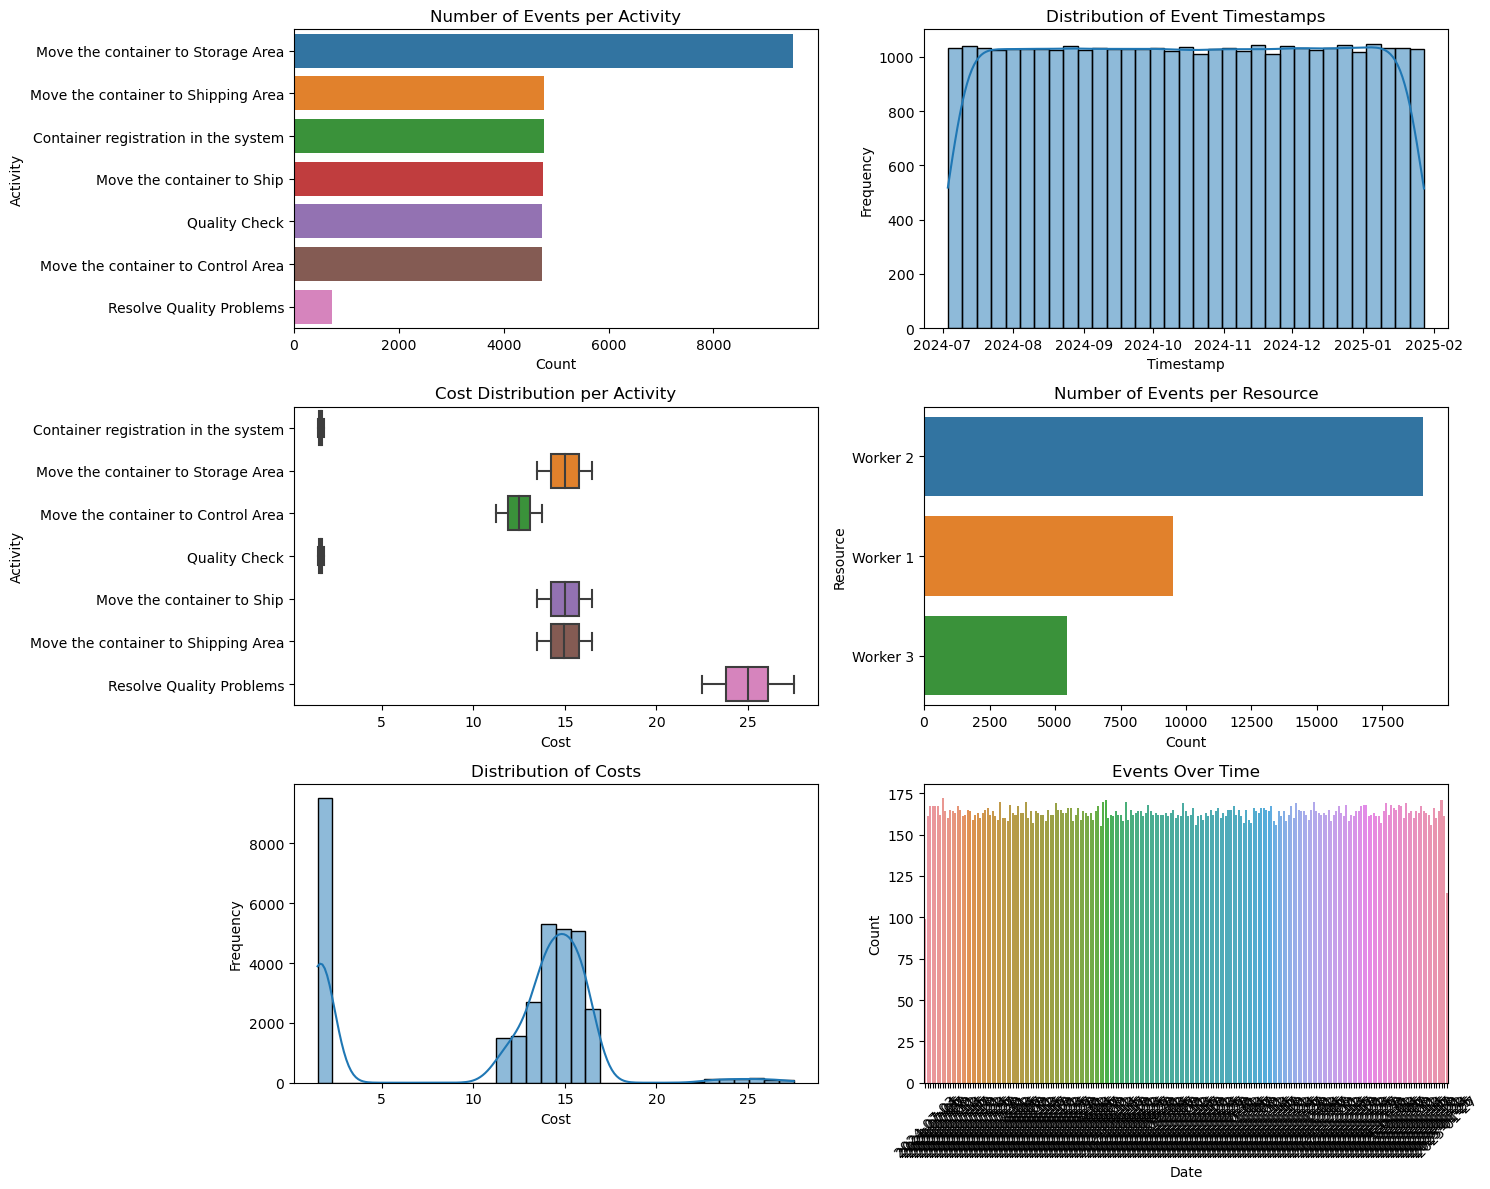

In [17]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
num_instances = 5000
start_time = datetime(2024, 7, 3, 8, 0)
workers = {"Worker 1": 20, "Worker 2": 30, "Worker 3": 25}
durations = {
    "Container registration in the system": timedelta(minutes=5),
    "Move the container to Storage Area": timedelta(minutes=30),
    "Move the container to Control Area": timedelta(minutes=30),
    "Quality Check": timedelta(minutes=5),
    "Resolve Quality Problems": timedelta(hours=1),
    "Move the container to Shipping Area": timedelta(minutes=30),
    "Move the container to Ship": timedelta(minutes=30)
}

# Noise parameters
missing_data_percentage = 0.05 # 10% missing data
duration_variability = 0.10 # 20% variability in activity duration

# Initialize DataFrame
columns = ["case:concept:name", "concept:name", "time:timestamp", "org:resource", "cost"]
data = []

for instance_id in range(1, num_instances + 1):
    current_time = start_time + timedelta(hours=(instance_id - 1))
    for activity, worker in [
        ("Container registration in the system", "Worker 1"),
        ("Move the container to Storage Area", "Worker 2"),
        ("Move the container to Control Area", "Worker 3"),
        ("Quality Check", "Worker 1")
    ]:
        duration = durations[activity] + timedelta(minutes=np.random.uniform(-duration_variability * durations[activity].total_seconds() / 60, duration_variability * durations[activity].total_seconds() / 60))
        end = current_time + duration
        cost = (duration.total_seconds() / 3600) * workers[worker]
        
        if np.random.rand() > missing_data_percentage:
            data.append([instance_id, activity, current_time, worker, cost])
        
        current_time = end
    
    if np.random.rand() < 0.15:  # 15% chance of quality problems
        activity, worker = "Resolve Quality Problems", "Worker 3"
        duration = durations[activity] + timedelta(minutes=np.random.uniform(-duration_variability * durations[activity].total_seconds() / 60, duration_variability * durations[activity].total_seconds() / 60))
        end = current_time + duration
        cost = (duration.total_seconds() / 3600) * workers[worker]
        
        if np.random.rand() > missing_data_percentage:
            data.append([instance_id, activity, current_time, worker, cost])
        
        current_time = end
    
    # Move to Storage Area after Quality Check or Resolve Quality Problems
    activity = "Move the container to Storage Area"
    worker = "Worker 2"
    duration = durations[activity] + timedelta(minutes=np.random.uniform(-duration_variability * durations[activity].total_seconds() / 60, duration_variability * durations[activity].total_seconds() / 60))
    end = current_time + duration
    cost = (duration.total_seconds() / 3600) * workers[worker]
    
    if np.random.rand() > missing_data_percentage:
        data.append([instance_id, activity, current_time, worker, cost])
    
    current_time = end

    # Continue the process normally to Shipping Area and Ship
    for activity, worker in [
        ("Move the container to Shipping Area", "Worker 2"),
        ("Move the container to Ship", "Worker 2")
    ]:
        duration = durations[activity] + timedelta(minutes=np.random.uniform(-duration_variability * durations[activity].total_seconds() / 60, duration_variability * durations[activity].total_seconds() / 60))
        end = current_time + duration
        cost = (duration.total_seconds() / 3600) * workers[worker]
        
        if np.random.rand() > missing_data_percentage:
            data.append([instance_id, activity, current_time, worker, cost])
        
        current_time = end

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Read the generated XES file
log = pm4py.read_xes("SmartHarbor_process_log.xes")

# Convert the log to a DataFrame
df_log = pm4py.convert_to_dataframe(log)

# Number of activities
num_activities = df_log['concept:name'].nunique()

# Number of resources
num_resources = df_log['org:resource'].nunique()

# Number of events
num_events = df_log.shape[0]

# Number of cases
num_cases = df_log['case:concept:name'].nunique()

# Number of execution variants
variants = pm4py.get_variants_as_tuples(log)
num_variants = len(variants)

# Display the extracted information
print(f"The process discovered from the log consists of {num_activities} activities, {num_resources} resources, {num_events} events related to {num_cases} cases, and {num_variants} different execution paths (process variants).")

# Convert DataFrame to event log and export to XES
log = pm4py.format_dataframe(df, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
pm4py.write_xes(log, "SmartHarbor_process_log.xes")

# Display basic statistics and visualizations
print("Basic Statistics")
print(df.describe(include='all', datetime_is_numeric=True))

plt.figure(figsize=(15, 12))
plt.subplot(3, 2, 1)
sns.countplot(y='concept:name', data=df, order=df['concept:name'].value_counts().index).set(title='Number of Events per Activity', xlabel='Count', ylabel='Activity')
plt.subplot(3, 2, 2)
sns.histplot(df['time:timestamp'], kde=True).set(title='Distribution of Event Timestamps', xlabel='Timestamp', ylabel='Frequency')
plt.subplot(3, 2, 3)
sns.boxplot(x='cost', y='concept:name', data=df).set(title='Cost Distribution per Activity', xlabel='Cost', ylabel='Activity')
plt.subplot(3, 2, 4)
sns.countplot(y='org:resource', data=df, order=df['org:resource'].value_counts().index).set(title='Number of Events per Resource', xlabel='Count', ylabel='Resource')
plt.subplot(3, 2, 5)
sns.histplot(df['cost'], kde=True).set(title='Distribution of Costs', xlabel='Cost', ylabel='Frequency')
plt.subplot(3, 2, 6)
df['date'] = df['time:timestamp'].dt.date
sns.countplot(x='date', data=df).set(title='Events Over Time', xlabel='Date', ylabel='Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import pm4py

# Leggi il file XES generato
log = pm4py.read_xes("SmartHarbor_process_log.xes")

# Converti il log in un DataFrame
df_log = pm4py.convert_to_dataframe(log)

# Numero di attività
num_activities = df_log['concept:name'].nunique()

# Numero di risorse
num_resources = df_log['org:resource'].nunique()

# Numero di eventi
num_events = df_log.shape[0]

# Numero di casi
num_cases = df_log['case:concept:name'].nunique()

# Numero di varianti di esecuzione
variants = pm4py.get_variants_as_tuples(log)
num_variants = len(variants)

# Visualizza le informazioni estratte
print(f"Il processo scoperto dal log consiste di {num_activities} attività, {num_resources} risorse, {num_events} eventi relativi a {num_cases} casi, e {num_variants} percorsi di esecuzione differenti (varianti di processo).")

parsing log, completed traces ::   0%|          | 0/5000 [00:00<?, ?it/s]

Il processo scoperto dal log consiste di 7 attività, 3 risorse, 33910 eventi relativi a 5000 casi, e 67 percorsi di esecuzione differenti (varianti di processo).
